# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [58]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_sim_2 import sim1d


from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind



### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




A full factorial DOE table is generated to study solidifcation time with the different factors and their corresponding levels.

In [59]:
# Create a full factorial design

num_levels = 2 
levels = [0, 1]
num_vars = 9
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design

doe_df_sol_time = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_sol_time.shape)

(512, 9)


The number of runs are large so a fractional factorial design is adopted.

In [60]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 9
design2 = fracfact('a b c d e  abcde abcd bcde adce ')
L_level = 0.99
R_level = 1.01
factor_levels = {
    'rho_l': [2760.0, 2860.0],
    'rho_s': [3000.0, 4000.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(32, 9)


In [61]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['total_sol_time'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

# print(Res_doe_sol_time.head(5))



In [62]:
# here the response values are calculated using sim1d function

for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    FracFact_doe_sol_time.at[i, 'total_sol_time'] = sim1d(*input_values)

 Histogram of the Total Solidifcation time is plotted

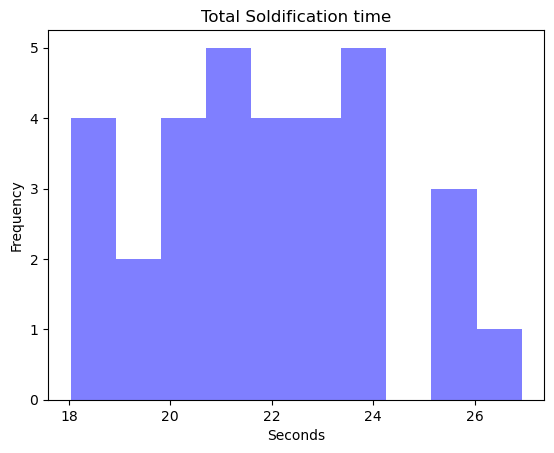

In [63]:
plt.hist(FracFact_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Regression model is developed

In [64]:


# Create the formula for the ANOVA
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     691.3
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           7.41e-25
Time:                        11:39:21   Log-Likelihood:                 18.429
No. Observations:                  32   AIC:                            -16.86
Df Residuals:                      22   BIC:                            -2.200
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The plots of the residuals vs. fitted values are shown below


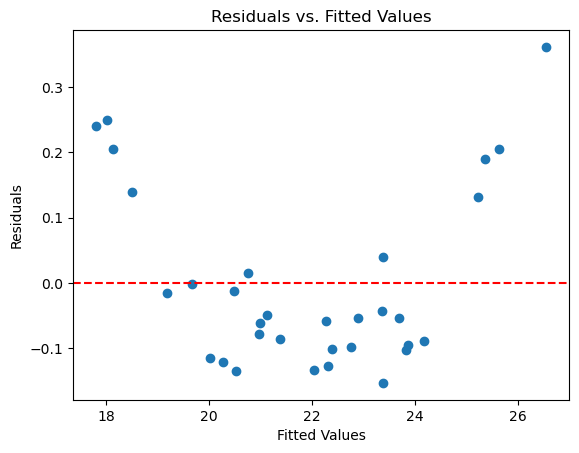

This is followed by the histogram of the residuals


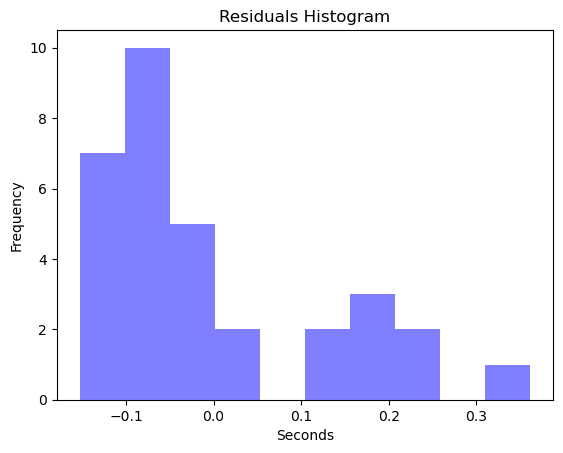

In [68]:
residuals_ols = model.resid
FracFact_doe_sol_time['Residuals'] =residuals_ols
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


print (f"This is followed by the histogram of the residuals")
plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

Residuals of the model was calculated and the its normality is checked

In [69]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.8478503220515109
p-value: 0.0003728233136330041
The residuals are not normally distributed (reject H0).


Log transformation is performed on the response variable and then new model is developed

In [70]:
transformed_data = np.log( FracFact_doe_sol_time['total_sol_time']+ 1)  # Add 1 to avoid log(0)
LogTrans_doe_sol_time = FracFact_doe_sol_time.copy()
LogTrans_doe_sol_time['transf_data'] = transformed_data

# Create the formula for the ANOVA
formula2 = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

# Fit the model
model2 = sm.OLS.from_formula(formula2, data=LogTrans_doe_sol_time).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     691.3
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           7.41e-25
Time:                        11:43:23   Log-Likelihood:                 18.429
No. Observations:                  32   AIC:                            -16.86
Df Residuals:                      22   BIC:                            -2.200
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Residuals of the new model is calcualted and normality tests are performed on the new model

In [71]:
residuals2 = model2.resid

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals2)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.9363033404292251
p-value: 0.05883935831901029
The residuals are normally distributed (fail to reject H0).


The plots of the residuals vs. fitted values are shown below


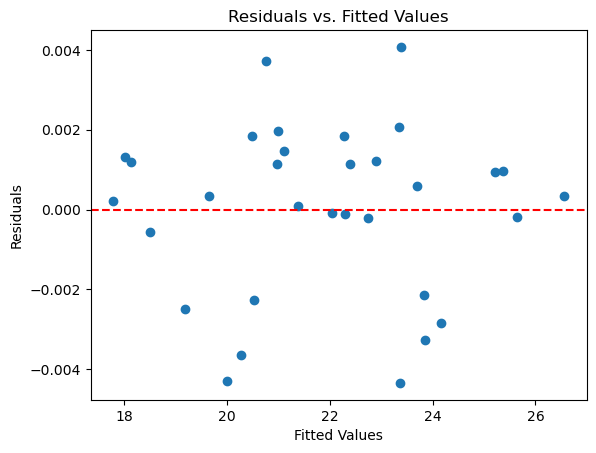

This is followed by the histogram of the residuals


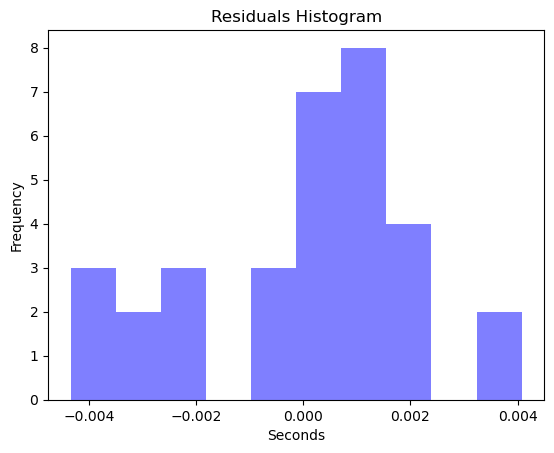

Breusch-Pagan test p-value: 0.9219992489137028


In [73]:
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


print (f"This is followed by the histogram of the residuals")
plt.hist(residuals2, bins=10, alpha=0.5, color='b')
plt.title('Residuals Histogram')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

f


Additional tests to check homodescasity is also performed and found to be non-existant

In [77]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
test_results = het_breuschpagan(residuals2, model2.model.exog)

# Extract the p-value
bp_test_stat, bp_test_pvalue = test_results[2], test_results[3]

print(f'Breusch-Pagan test p-value: {bp_test_pvalue}')

if bp_test_pvalue > 0.05:
    print('The residuals are not homoscedastic')
else:
    print('The residuals are homoscedastic')

from statsmodels.stats.diagnostic import het_white

# Perform White's test
test_results = het_white(residuals2, model2.model.exog)

# Extract the p-value
white_test_stat, white_test_pvalue = test_results[2], test_results[3]

print(f'White\'s test p-value: {white_test_pvalue}')

if white_test_pvalue > 0.05:
    print('The residuals are not heteroscedastic')  
else:
    print('The residuals are heteroscedastic')

Breusch-Pagan test p-value: 0.9219992489137028
The residuals are not homoscedastic
White's test p-value: 0.9362764835549762
The residuals are not heteroscedastic


ANOVA Test of the model

In [78]:
from statsmodels.formula.api import ols
# Create the formula for the ANOVA
formula = 'transf_data ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp)+ C(L_fusion) + C(temp_init)'

# Fit the model
model_anova = ols(formula, data=LogTrans_doe_sol_time).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model_anova, typ=2)

# Display the ANOVA results
print(anova_results)
print(model.summary())

                sum_sq    df             F        PR(>F)
C(rho_l)      0.002040   1.0    314.547894  1.615667e-14
C(rho_s)      0.170028   1.0  26215.893140  2.423222e-35
C(k_l)        0.085708   1.0  13215.012363  4.498690e-32
C(k_s)        0.054060   1.0   8335.242992  7.083959e-30
C(cp_l)       0.000057   1.0      8.820024  7.071150e-03
C(cp_s)       0.000004   1.0      0.691306  4.146541e-01
C(Surr_temp)  0.002901   1.0    447.344319  4.126449e-16
C(L_fusion)   0.003425   1.0    528.084831  7.175141e-17
C(temp_init)  0.001739   1.0    268.173453  8.295797e-14
Residual      0.000143  22.0           NaN           NaN
                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     691.3
Date:                Tue, 02 Jul 2024   Prob (F-statistic

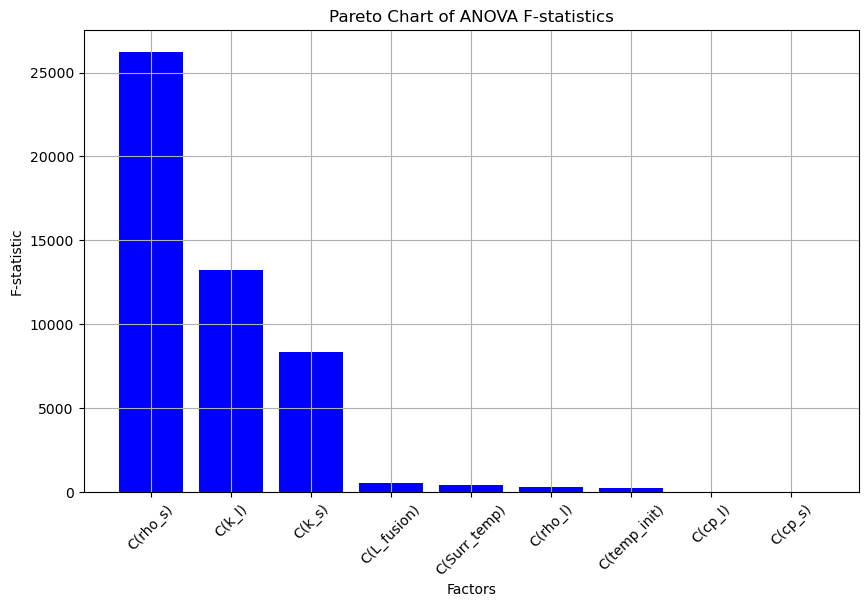

In [79]:
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Checking for Multicollinearity

In [81]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'data' is your DataFrame
X =LogTrans_doe_sol_time[['rho_l', 'rho_s', 'k_l', 'k_s', 'Surr_temp', 'L_fusion', 'temp_init']]
y =LogTrans_doe_sol_time['total_sol_time']

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

# Check VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     897.6
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           1.92e-27
Time:                        12:54:47   Log-Likelihood:                 17.198
No. Observations:                  32   AIC:                            -18.40
Df Residuals:                      24   BIC:                            -6.669
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.9831      6.050     -6.444      0.0

Latin Hypercube Sampling is then explored.

In [16]:
n_factors = 9
n_levels = 2

# Create a Latin Hypercube Design

from pyDOE2 import lhs

design3 = lhs(n_factors, samples=100)
factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())
doe_lhs = pd.DataFrame(design3, columns=factor_names)

for i, (lower, upper) in enumerate(factor_levels.values()):
    doe_lhs.iloc[:, i] = lower + doe_lhs.iloc[:, i] * (upper - lower)



In [17]:
Lhs_doe_sol_time = doe_lhs.copy()

Lhs_doe_sol_time['total_sol_time'] = [0.0] * Lhs_doe_sol_time.shape[0]

for i in range(Lhs_doe_sol_time.shape[0]):
    input_values = Lhs_doe_sol_time.iloc[i,:-1].values
    Lhs_doe_sol_time.at[i, 'total_sol_time'] = sim1d(*input_values)

print(Lhs_doe_sol_time.shape)

(100, 10)


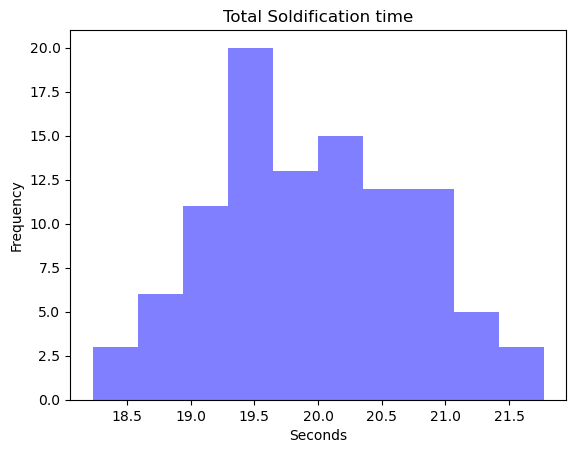

In [18]:
plt.hist(Lhs_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

In [19]:
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

model_lhs = sm.OLS.from_formula(formula, data=Lhs_doe_sol_time).fit()
residual_lhs_ols = model_lhs.resid
Lhs_doe_sol_time['Residuals'] = residual_lhs_ols
print(model_lhs.summary())

                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                nan
Time:                        09:57:37   Log-Likelihood:                 2959.2
No. Observations:                 100   AIC:                            -5718.
Df Residuals:                       0   BIC:                            -5458.
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


Shapiro-Wilk Test Statistic: 0.8515549234358046
p-value: 1.3541608723120122e-08
The residuals are not normally distributed (reject H0).


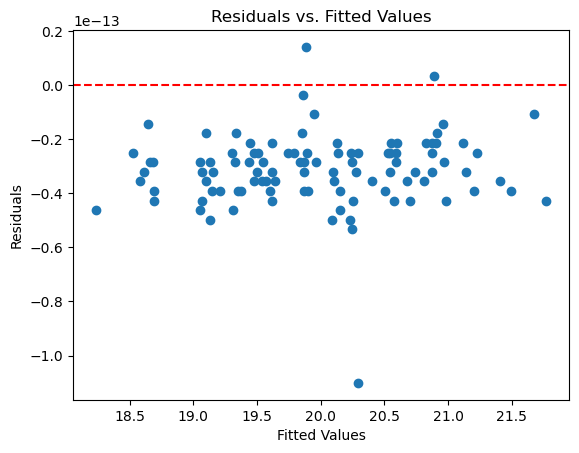

In [20]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual_lhs_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


# Plot residuals vs. fitted values
plt.scatter(model_lhs.fittedvalues, residual_lhs_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The normality of the Residuals are still not satisfied so sobol sampling will be explored 

In [36]:


# Create a Latin Hypercube Design

from scipy.stats import qmc

n_factors = 9
n_samples =200

design_sobol = qmc.Sobol(n_factors, scramble=True).random(n_samples)

# print(sobol_sample)

factor_levels = {
    'rho_l': [2760.0, 2761.0],
    'rho_s': [3000.0, 3001.0],
    'k_l': [96.0, 120.0],
    'k_s': [110.0, 130.0],
    'cp_l': [927.0, 947.0],
    'cp_s': [967.0, 987.0],
    'Surr_temp': [313.0, 323.0],
    'L_fusion': [389e3, 400e3 ],
    'temp_init': [880.0, 890.0],

}

factor_names = list(factor_levels.keys())
doe_sobol = pd.DataFrame(design_sobol, columns=factor_names)

for i, (lower, upper) in enumerate(factor_levels.values()):
    doe_sobol.iloc[:, i] = lower + doe_sobol.iloc[:, i] * (upper - lower)

sobol_doe_sol_time = doe_sobol.copy()

sobol_doe_sol_time['total_sol_time'] = [0.0] * sobol_doe_sol_time.shape[0]

for i in range(sobol_doe_sol_time.shape[0]):
    input_values = sobol_doe_sol_time.iloc[i,:-1].values
    sobol_doe_sol_time.at[i, 'total_sol_time'] = sim1d(*input_values)

print(sobol_doe_sol_time.shape)



/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


(200, 10)


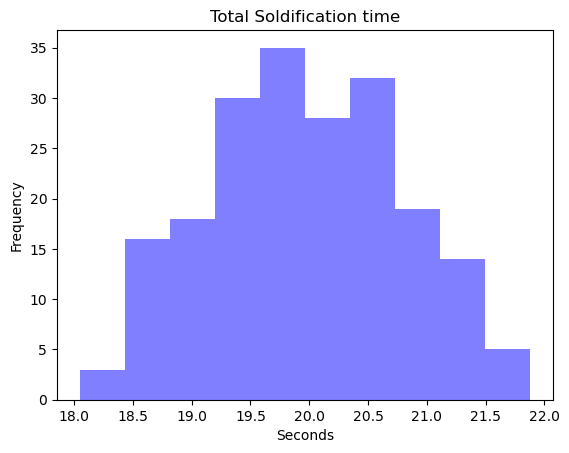

In [37]:
plt.hist(sobol_doe_sol_time['total_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Total Soldification time')
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.show()

In [38]:
formula = 'total_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) + C(temp_init)'

model_sobol = sm.OLS.from_formula(formula, data=sobol_doe_sol_time).fit()
residual_sobol_ols = model_sobol.resid
sobol_doe_sol_time['Residuals'] = residual_sobol_ols
print(model_sobol.summary())

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


                            OLS Regression Results                            
Dep. Variable:         total_sol_time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                nan
Time:                        11:20:06   Log-Likelihood:                 6055.9
No. Observations:                 200   AIC:                        -1.171e+04
Df Residuals:                       0   BIC:                        -1.105e+04
Df Model:                         199                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

Shapiro-Wilk Test Statistic: 0.9525016636670907
p-value: 3.3128726625586185e-06
The residuals are not normally distributed (reject H0).


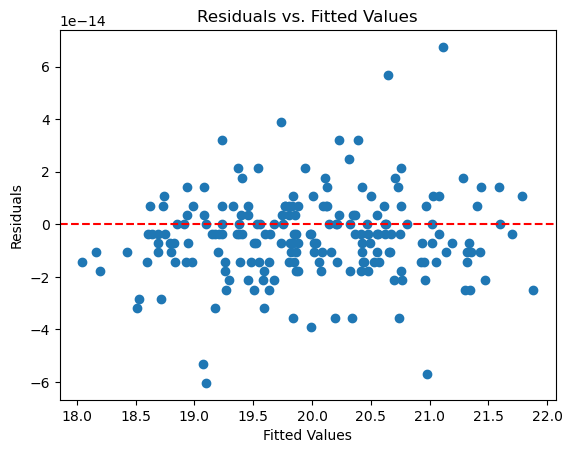

In [39]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residual_sobol_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


# Plot residuals vs. fitted values
plt.scatter(model_sobol.fittedvalues, residual_sobol_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()